In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2,os
from scipy import io
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
pi = np.pi

In [14]:
# set paths for video frames and calibration data
src = './sample_frames/'
calibpath = './camera_data/'

In [104]:
# create functions that supply necessary calibration data and tranformations

# get the correct camera
insta1dates = ['Oct16','Oct17','Oct18','Oct19']
insta2dates = ['Oct12', 'Oct13', 'Oct14','Oct15']
def getinsta(filename):
    insta = -1
    for date in insta1dates:
        if date in filename:
            insta = 1
    for date in insta2dates:
        if date in filename:
            if insta == 1:
                print(f'error in getinsta on {filename}')
            insta = 2
    return insta
sig1 = 3
sig2 = 2

# look up tables to convert pixel values to units that are linear with respect to luminance
LUT01 = io.loadmat(calibpath+'insta1_pixel_value_LUT.mat')
LUT02 = io.loadmat(calibpath+'insta2_pixel_value_LUT.mat')
LUT1 = np.stack([LUT01['R_response_LUT'][0],LUT01['G_response_LUT'][0],LUT01['B_response_LUT'][0]],axis=-1)
LUT2 = np.stack([LUT02['R_response_LUT'][0],LUT02['G_response_LUT'][0],LUT02['B_response_LUT'][0]],axis=-1)
def lummap(im,insta):
    if insta == 1:
        lum = np.stack([cv2.LUT((im[:,:,i]).astype('uint8'),LUT1[:,i]) for i in range(3)],axis=-1).astype('float32')
    else:
        lum = np.stack([cv2.LUT((im[:,:,i]).astype('uint8'),LUT2[:,i]) for i in range(3)],axis=-1).astype('float32')
    return lum

# pixel location to equirectangular projection
projmaps_dict = np.load(calibpath+'equirectangular_projmaps.npz') # LUT to remap fish eye lens distortion into an equiangular projection
projmaps      = projmaps_dict['projmaps'] # select entry from dictionary
case_dict     = np.load(calibpath+'dive_case_proj_clipped.npz') # dive case mask in equirectangular projection
case          = case_dict['case'] # select entry from dictionary


# pixel location to world location (coordinate on imaginary sphere)
pts3d = np.zeros([1504*1504,3,3,2])
for insta in [1,2]:
    for cam in [0,1]:
        calibdata = io.loadmat(calibpath+f'spherical_coordinates_insta{insta}_water.mat')
        pts3d[:,0,insta,cam] = np.ndarray.flatten(calibdata[f'sphericalCam{cam+1}G']['x'][0][0])
        pts3d[:,1,insta,cam] = np.ndarray.flatten(calibdata[f'sphericalCam{cam+1}G']['y'][0][0])
        pts3d[:,2,insta,cam] = np.ndarray.flatten(calibdata[f'sphericalCam{cam+1}G']['z'][0][0])
        
def Rx(gamma):
    return [[1,0,0],[0,np.cos(gamma),-np.sin(gamma)],[0,np.sin(gamma),np.cos(gamma)]]

def Ry(beta):
    return [[np.cos(beta),0,np.sin(beta)],[0,1,0],[-np.sin(beta),0,np.cos(beta)]]

def Rz(alpha):
    return [[np.cos(alpha),-np.sin(alpha),0],[np.sin(alpha),np.cos(alpha),0],[0,0,1]]

def makeR(yaw,pitch=0,roll=0):
    return np.matmul(np.matmul(Rx(pitch),Ry(yaw)),Rz(roll))

In [105]:
# undistort whole image, map to equirectangular projection, and mask out dive case
def projim(filename,lum=False):
    insta = getinsta(filename)
    im = cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2RGB)
    for c in range(3):
        im[:,:1504,c] = gaussian_filter(im[:,:1504,c],sig1)
        im[:,1504:,c] = gaussian_filter(im[:,1504:,c],sig2)
    if lum:
        im = lummap(im,insta)
    out = np.zeros_like(im)
    out[:,:1504,:] = cv2.remap(np.rot90(im[:,:1504,:],3),projmaps[insta,:,:1504,:],None,interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    out[:,1504:,:] = cv2.remap(np.rot90(im[:,1504:,:],1),projmaps[insta,:,1504:,:],None,interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    return (np.flipud(out)*case).astype('uint8') # return image with divecase mask applied

In [108]:
# project a single tangent patch
def tanlumfromfile(filename,pitch=0,yaw=0,FOV=40,res=40,foclen=1.0,lum=False):
    insta = getinsta(filename)
    im = cv2.imread(filename)
    # convert to luminance
    if lum:
        im = lummap(im,insta)
    im = im[:,:,1] # just green color channel (the channel that we loaded the spherical coordinates for)
    # blur to match across cameras
    if np.abs(yaw) < pi/2:
        cam = 0
        im = gaussian_filter(np.rot90(im[:,:1504],3),sig1)
    else:
        cam = 1
        yaw = (yaw-pi)%pi
        im = gaussian_filter(np.rot90(im[:,1504:]),sig2)
    # rotate view
    R = makeR(yaw,pitch)
    rotpts3d = np.matmul(pts3d[:,:,insta,cam],R)
    X = rotpts3d[:,0].reshape([1504,1504])
    Y = rotpts3d[:,1].reshape([1504,1504])
    Z = rotpts3d[:,2].reshape([1504,1504])
    x = X*foclen/(Z+1e-10)
    y = Y*foclen/(Z+1e-10)
    # limit field of view
    lim = np.tan(FOV/2*pi/180)
    clip = ~np.logical_or(np.logical_or(x>lim,x<-lim),np.logical_or(y>lim,y<-lim))
    # reproject image
    pixx,pixy = np.meshgrid(np.linspace(-lim,lim,res+2),np.linspace(-lim,lim,res+2)) #res+2 & clipping to remove edge nans
    interp = griddata((x[clip],y[clip]),im[clip],(pixx,pixy),'cubic')
    return interp[1:-1,1:-1]

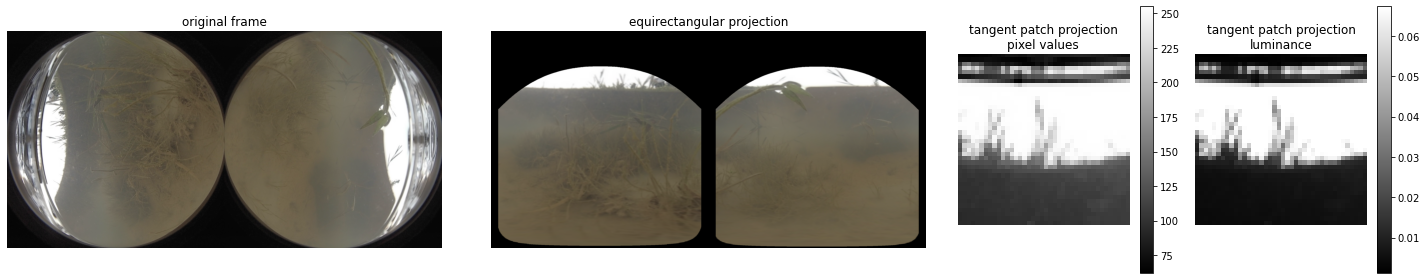

In [109]:
# demonstrate image transformation functions
png = src+'Vz_60/Oct12/0.png'
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.imshow(plt.imread(png))
plt.axis('off')
plt.title('original frame')
plt.subplot(1,3,2)
plt.imshow(projim(png))
plt.axis('off')
plt.title('equirectangular projection')
plt.subplot(1,6,5)
plt.imshow(tanlumfromfile(png,pitch=-40,yaw=0),cmap='gray')
plt.title('tangent patch projection\npixel values')
plt.axis('off')
plt.colorbar()
plt.subplot(1,6,6)
plt.imshow(tanlumfromfile(png,pitch=-40,yaw=0,lum=True),cmap='gray')
plt.title('tangent patch projection\nluminance')
plt.colorbar()
plt.axis('off')
plt.tight_layout()

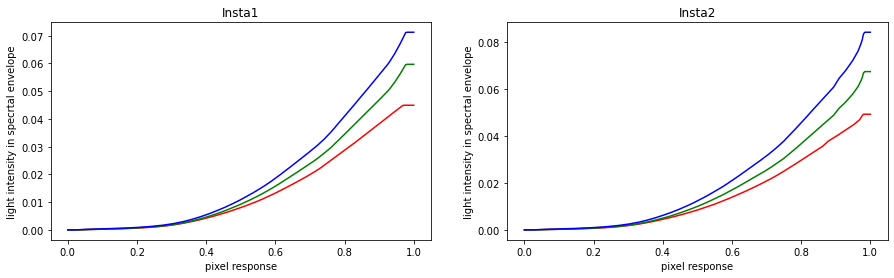

In [33]:
# plot linearizing LUT
plt.figure(figsize=(15,4))

# plot insta 1
plt.subplot(1,2,1);
plt.title('Insta1')
plt.plot(np.linspace(0,1,256),LUT1[:,0],'r-');
plt.plot(np.linspace(0,1,256),LUT1[:,1],'g-');
plt.plot(np.linspace(0,1,256),LUT1[:,2],'b-');
plt.xlabel('pixel response');
plt.ylabel('light intensity in specrtal envelope');

# plot insta 2
plt.subplot(1,2,2);
plt.title('Insta2')
plt.plot(np.linspace(0,1,256),LUT2[:,0],'r-');
plt.plot(np.linspace(0,1,256),LUT2[:,1],'g-');
plt.plot(np.linspace(0,1,256),LUT2[:,2],'b-');
plt.xlabel('pixel response');
plt.ylabel('light intensity in specrtal envelope');

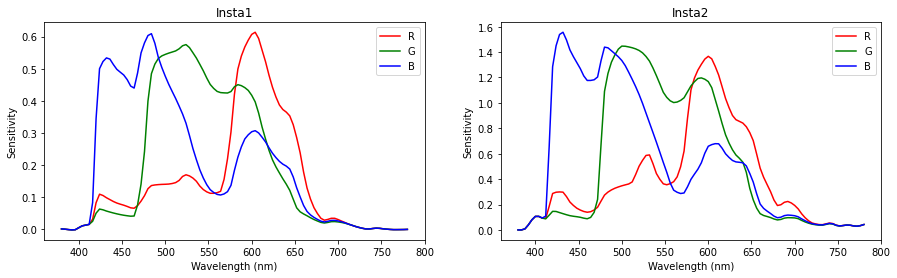

In [32]:
# plot spectral sensitivity envelopes
insta1 = io.loadmat('./camera_data/insta1_spectral_sensitivity.mat');
insta2 = io.loadmat('./camera_data/insta2_spectral_sensitivity.mat');
wv_measures = np.linspace(380,780,num = 101) # wavelengths of narrowband light sources in nm

plt.figure(figsize=(15,4))

# plot insta1 (manuscript figure)
plt.subplot(1,2,1);
plt.plot(wv_measures, np.squeeze(insta1.get('avgR')), 'r-');
plt.plot(wv_measures, np.squeeze(insta1.get('avgG')), 'g-');
plt.plot(wv_measures, np.squeeze(insta1.get('avgB')), 'b-');
plt.legend(['R','G','B']);
plt.xlabel('Wavelength (nm)');
plt.ylabel('Sensitivity');
plt.title('Insta1');

# plot insta2
plt.subplot(1,2,2);
plt.plot(wv_measures, np.squeeze(insta2.get('avgR')), 'r-');
plt.plot(wv_measures, np.squeeze(insta2.get('avgG')), 'g-');
plt.plot(wv_measures, np.squeeze(insta2.get('avgB')), 'b-');
plt.legend(['R','G','B'])
plt.xlabel('Wavelength (nm)');
plt.ylabel('Sensitivity');
plt.title('Insta2');

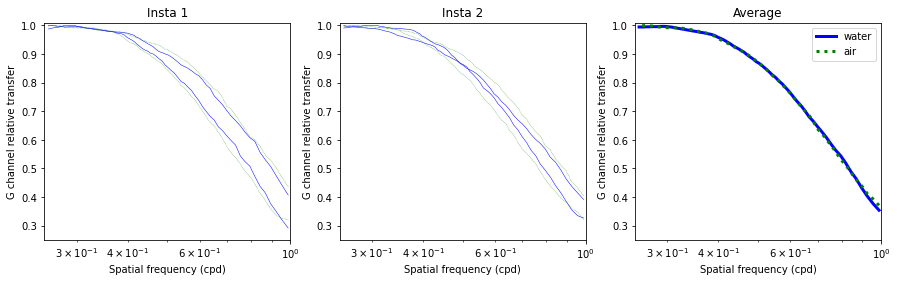

In [40]:
# plot intensity transfer as a function of spatial frequency along the central optical axis
insta1 = io.loadmat('./camera_data/insta1_mtf.mat');
insta2 = io.loadmat('./camera_data/insta2_mtf.mat');

plt.figure(figsize=(15,4))

# plot insta1 
plt.subplot(1,3,1);
plt.title('Insta 1')
plt.plot(np.squeeze(insta1.get('resCycDeg_trim')),np.squeeze(insta1.get('cam1_water')),'b-',linewidth=0.5);
plt.plot(np.squeeze(insta1.get('resCycDeg_trim')),np.squeeze(insta1.get('cam2_water')),'b-',linewidth=0.5);
plt.plot(np.squeeze(insta1.get('resCycDeg_trim')),np.squeeze(insta1.get('cam1_air')),'g:',linewidth=0.5);
plt.plot(np.squeeze(insta1.get('resCycDeg_trim')),np.squeeze(insta1.get('cam2_air')),'g:',linewidth=0.5);

plt.xscale('log');
plt.xlim((0.25,1));
plt.ylim((0.25,1.01));
plt.xlabel('Spatial frequency (cpd)');
plt.ylabel('G channel relative transfer');

# plot insta2
plt.subplot(1,3,2);
plt.title('Insta 2')
plt.plot(np.squeeze(insta2.get('resCycDeg_trim')),np.squeeze(insta2.get('cam1_water')),'b-',linewidth=0.5);
plt.plot(np.squeeze(insta2.get('resCycDeg_trim')),np.squeeze(insta2.get('cam2_water')),'b-',linewidth=0.5);
plt.plot(np.squeeze(insta2.get('resCycDeg_trim')),np.squeeze(insta2.get('cam1_air')),'g:',linewidth=0.5);
plt.plot(np.squeeze(insta2.get('resCycDeg_trim')),np.squeeze(insta2.get('cam2_air')),'g:',linewidth=0.5);

plt.xscale('log');
plt.xlim((0.25,1));
plt.ylim((0.25,1.01));
plt.xlabel('Spatial frequency (cpd)');
plt.ylabel('G channel relative transfer');

# average over all cameras for measurements taken in water and air
water = np.concatenate((insta1.get('cam1_water'),insta1.get('cam2_water'),insta2.get('cam1_water'),insta2.get('cam2_water')),axis=0);
mean_water = np.mean(water,axis=0);
air = np.concatenate((insta1.get('cam1_air'),insta1.get('cam2_air'),insta2.get('cam1_air'),insta2.get('cam2_air')),axis=0);
mean_air = np.mean(air,axis=0);

# plot averages
plt.subplot(1,3,3);
plt.title('Average')
plt.plot(np.squeeze(insta1.get('resCycDeg_trim')),mean_water,'b-',linewidth=3,label='water');
plt.plot(np.squeeze(insta1.get('resCycDeg_trim')),mean_air,'g:',linewidth=3,label='air');

plt.xscale('log');
plt.xlim((0.25,1));
plt.ylim((0.25,1.01));
plt.xlabel('Spatial frequency (cpd)');
plt.ylabel('G channel relative transfer');
plt.legend();